In [71]:
import torch
import torchvision

In [111]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [112]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [113]:
# Now let's take a look at some examples. We'll use the test_loader for this.
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

# example_targets.shape

torch.Size([1000, 1, 28, 28])

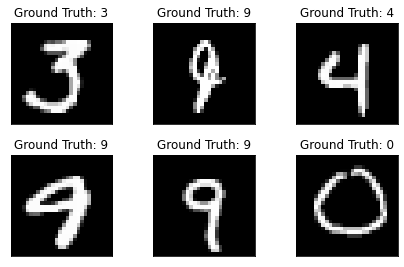

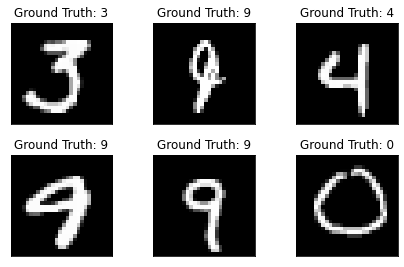

In [114]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [115]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [117]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [118]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [119]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [120]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [121]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


<ipython-input-116-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

Evaluating the Model's Performance

And that's it. With just 3 epochs of training we already managed to achieve 97% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 10% accuracy on the test set before starting the training.

Let's plot our training curve.

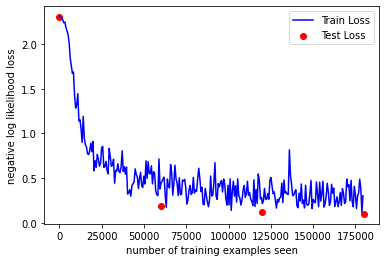

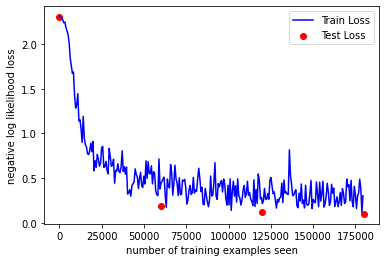

In [122]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

looks like we could even continue training for a few more epochs!

But before that let's again look at a few examples as we did earlier and compare the model's output.

In [123]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-116-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


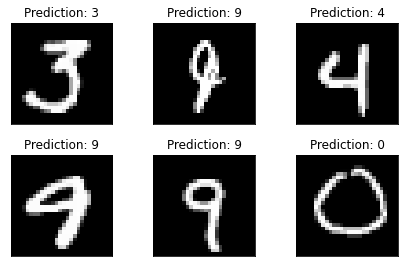

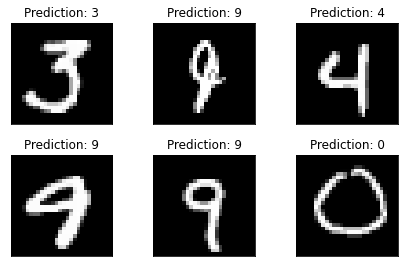

In [124]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Continued Training from Checkpoints

Now let's continue training the network, or rather see how we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [125]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

Using .load_state_dict() we can now load the internal state of the network and optimizer when we last saved them.

In [127]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [93]:
!pip install pyyaml==5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 662 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.3.1
    Uninstalling PyYAML-5.3.1:
      Successfully uninstalled PyYAML-5.3.1


Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [128]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-116-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.208578
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.362787
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.333615
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.426016
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.480444
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.132955
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.287925
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.335721
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.147954
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.196418
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.154988
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.164102
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.217753
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.395624
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.450458
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.152898
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150686
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.467977
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.139718
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.232057
Train Epoch: 4 [12800/60000 (

Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

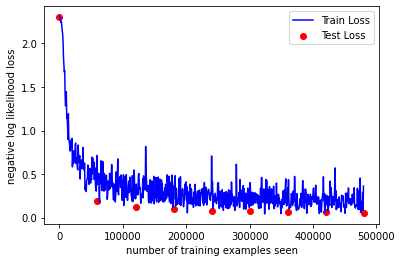

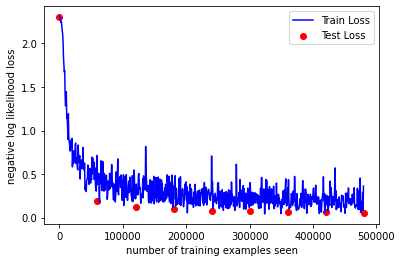

In [129]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

That still looks like a rather smooth learning curve just as if we initially would've trained for 8 epochs! Remember that we just appended values to the same lists starting from the 5th red dot onward.

From this we can conclue two things:

1. Continuing from the checkpointed internal state worked as intended.

2. We still don't seem to run into overfitting issues! It looks like our dropout layers did a good job regularizing the model.